Clustering and Classification
=======================

This chapter is a direct extension of the last. In Chapter 4, we learned how to build a corpus from a collection of 
text files and produce different metrics about them using a document-term matrix. For the most part these metrics 
hewed either toward the level of documents or the level of terms; we hadn't yet discussed ways to more fully weave 
these two aspects of our corpus together. We'll do so now. In this chapter, we will learn how to identify 
similarities between texts using a more general measure of the various features recorded in a document-term matrix. 
With this measure, we'll be able to cluster the obituaries in our corpus into distinct groups, which may in turn 
tell us something about the overall shape of our corpus, its trends, its patterns, etc.

The applications of this technique are broad. Search engines use text similarity to identify relevant results for 
queries; literature scholars consult it to investigate authorship and topicality. Below, we'll walk through the 
concepts that underly text similarity show a few examples of how to explore and interpret the results of this 
measure.

```{admonition} Learning objectives
By the end of this chapter, you will be able to:
+ Rank documents by similarity, using a cosine distance measure
+ Project documents into a feature space to visualize their similarities
+ Cluster documents by their similarities
```

The Vector Space Concept
-------------------------------

To measure similarities between documents, we need to make a bit of a conceptual leap. Imagine projecting every 
document in our corpus into a space. In this space, similar documents have similar orientations to a point of 
origin (in this case, the origin point of XY axes), while dissimilar ones have different orientations. Guiding 
these orientations are the values for each term in a document. Here, _space is a metaphor for semantics_.

### Plotting an example

We can build a toy example to demonstrate this. Imagine two documents, each with a value for two terms.

In [1]:
import pandas as pd
import numpy as np

ex1 = np.array([[18, 7], [4, 12]])
ex1_dtm = pd.DataFrame(ex1, columns = ['page', 'screen'], index = ['Document 1', 'Document 2'])
ex1_dtm

,page,screen
Document 1,18,7
Document 2,4,12


Since there are only two terms here, we can directly plot this data using XY coordinates.

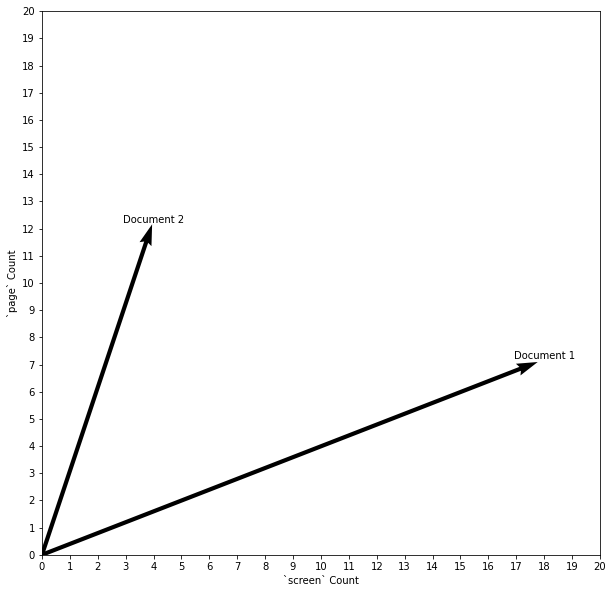

In [2]:
import matplotlib.pyplot as plt

origin = np.array([[0, 0], [0, 0]])

fig, ax = plt.subplots(figsize = (10, 10))
plt.quiver(*origin, ex1_dtm['page'], ex1_dtm['screen'], scale = 1, units = 'xy')
plt.setp(ax, xlim = (0, 20), ylim = (0, 20), xticks = range(0, 21), yticks = range(0, 21))
plt.setp(ax, xlabel = '`screen` Count', ylabel = '`page` Count')

for doc in ex1_dtm.index:
    plt.text(
        ex1_dtm.loc[doc, 'page'],
        ex1_dtm.loc[doc, 'screen'] + 0.5,
        doc,
        va = 'top',
        ha = 'center'
    )

plt.show()

In this plot, we're particularly interested in the angle created by the two documents. Right now, this angle is 
fairly wide, as the differences between the two counts in each document are rough inverses of one another. Document 
1 has more counts for "page" than "screen," whereas Document 2 is the other way around.

But if we change the counts in Document 1 to be more like those in Document 2...

In [3]:
ex2 = np.array([[10, 18], [4, 12]])
ex2_dtm = pd.DataFrame(ex2, columns = ['page', 'screen'], index = ['Document 1', 'Document 2'])
ex2_dtm

,page,screen
Document 1,10,18
Document 2,4,12


...and replot our documents...

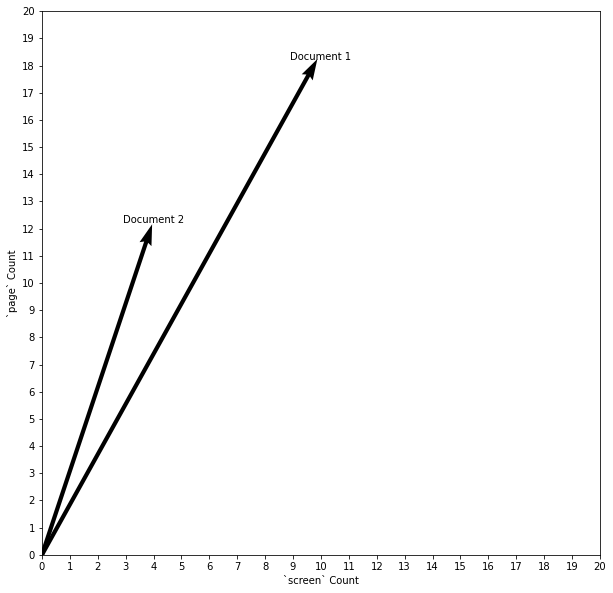

In [4]:
fig, ax = plt.subplots(figsize = (10, 10))
plt.quiver(*origin, ex2_dtm['page'], ex2_dtm['screen'], scale = 1, units = 'xy')
plt.setp(ax, xlim = (0, 20), ylim = (0, 20), xticks = range(0, 21), yticks = range(0, 21))
plt.setp(ax, xlabel = '`screen` Count', ylabel = '`page` Count')

for doc in ex2_dtm.index:
    plt.text(
        ex2_dtm.loc[doc, 'page'],
        ex2_dtm.loc[doc, 'screen'] + 0.5,
        doc,
        va = 'top',
        ha = 'center'
    )

plt.show()

...we'll see that the angle has shrunk considerably. Document 1 is more like Document 2. Importantly, this 
similarity is relatively impervious to the actual value for each word. The counts for Document 1 and Document 2 are 
still quite different, but the _overall relationship_ between the values for each word is now similar: both 
documents have more instances of "screen" than "page," and our method of projecting them into this space, or what 
we call a **vector space**, captures this.

### Cosine similarity

We can assign a concrete metric to the difference in these angles using a **cosine similarity** score. Cosine 
similarity measures the inner product space between two vectors, that is, the amount of space created by 
divergences in the attribute values of each vector. Typically, we express it within a bounded interval, [0,1], 
where 0 stands for a right angle between two vectors and 1 measures vectors that completely overlap.

Formally, we express cosine similarity as

$$
similarity_{xy} = \frac{x \cdot y}{\Vert x \Vert \cdot \Vert y \Vert}
$$

where $x \cdot y$ is the dot product of two vectors. But we don't need to worry about implementing this ourselves. 
`scikit-learn` has a one-liner for this, which we can use on our two example vectors to demontrate how it works. It 
will output a square matrix of values, where each cell is the cosine similarity measure of the intersection between 
a column and a row. (You'll note, for example, that there are 1s in the following matrices: these are the 
intersections of a document with itself.)

In [5]:
from sklearn.metrics.pairwise import cosine_similarity

print("Cosine similarity for first example, where:")
for idx in ex1_dtm.index:
    display(ex1_dtm.loc[idx])
    
display(pd.DataFrame(cosine_similarity(ex1), columns = ex1_dtm.index, index = ex1_dtm.index))
print(f"...or, simplified: {cosine_similarity(ex1)[0][1]:0.2f}")

Cosine similarity for first example, where:


page      18
screen     7
Name: Document 1, dtype: int64

page       4
screen    12
Name: Document 2, dtype: int64

,Document 1,Document 2
Document 1,1.000000,0.638572
Document 2,0.638572,1.000000


...or, simplified: 0.64


In [6]:
print("Cosine similarity for second example, where:")
for idx in ex2_dtm.index:
    display(ex2_dtm.loc[idx])
    
display(pd.DataFrame(cosine_similarity(ex2), columns = ex2_dtm.index, index = ex2_dtm.index))
print(f"...or, simplified: {cosine_similarity(ex2)[0][1]:0.2f}")

Cosine similarity for second example, where:


page      10
screen    18
Name: Document 1, dtype: int64

page       4
screen    12
Name: Document 2, dtype: int64

,Document 1,Document 2
Document 1,1.000000,0.982872
Document 2,0.982872,1.000000


...or, simplified: 0.98


Of the two examples, which one has more similar documents? Our second one: the cosine similarity score is 0.98, far 
higher than 0.64.

Measuring Similarity
------------------------

With the principles of text similarity laid out, we can load in the document-matrix we've already created and, for 
each text in our corpus, compute a cosine similarity measure between that text and all the others. But rather 
than only measuring the attribute values between two terms, as above, we'll instead measure the values of every 
single tf-idf score in our corpus.

In [7]:
indir = "data/session_two/output/"
dtm = pd.read_csv(indir + "tfidf_scores.csv", index_col = 0)

dtm.iloc[:5, 100:115]

,absorb,absorbed,absorption,abstain,abstemious,abstemiousness,abstention,abstinence,abstinent,abstract,abstraction,abstractions,abstracts,abstruse,absurd
NAME,,,,,,,,,,,,,,,
Ada Lovelace,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.055834,0.0,0.0,0.0,0.0,0.0
Robert E Lee,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
Andrew Johnson,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
Bedford Forrest,0.0,0.0,0.0,0.0,0.023602,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
Lucretia Mott,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


In other words, rather than our stories having only two attributes, they'll have...

In [8]:
print("Number of each attributes per text:", len(dtm.columns))

Number of each attributes per text: 32548


We're working in very high-dimensional space!

### Generating scores

While this might be a bit hard to conceptualize (and indeed impossible to visualize), we can let `scikit-learn` do 
the heavy lifting and inspect the condensed results. Doing so involves simply running `cosine_similarity()` across 
the entire dataframe and assign the result to a new dataframe. The result will be a square matrix, where rows and 
columns are each of the texts in our corpus.

In [9]:
similarities = pd.DataFrame(
    cosine_similarity(dtm),
    columns = dtm.index,
    index = dtm.index
)

similarities.iloc[:5, :5]

NAME,Ada Lovelace,Robert E Lee,Andrew Johnson,Bedford Forrest,Lucretia Mott
NAME,,,,,
Ada Lovelace,1.000000,0.019792,0.026927,0.019026,0.019723
Robert E Lee,0.019792,1.000000,0.139954,0.157277,0.030560
Andrew Johnson,0.026927,0.139954,1.000000,0.098129,0.055867
Bedford Forrest,0.019026,0.157277,0.098129,1.000000,0.018065
Lucretia Mott,0.019723,0.030560,0.055867,0.018065,1.000000


Now we can identify the most and least similar texts to a given obituary. Note that we need to get the second index 
position for `most`, since the highest score will always be the obituary's similarity to itself.

```{margin} What this loop does
1. For each person, sort every associated value, getting the second to highest first
2. Sort again and get the lowest value
```

In [10]:
people = ['Ada Lovelace', 'Henrietta Lacks', 'FDR', 'Miles Davis']
for person in people:
    most = similarities.loc[person].sort_values(ascending = False).take([1])
    least = similarities.loc[person].sort_values().take([0])
    print(
        f"For {person}:",
        f"\n+ Most similar: {most.index[0]} ({most[0]:0.3f} cosine similarity)",
        f"\n+ Least similar: {least.index[0]} ({least[0]:0.3f} cosine similarity)",
        "\n"
    )

For Ada Lovelace: 
+ Most similar: Karen Sparck Jones (0.180 cosine similarity) 
+ Least similar: Lou Gehrig (0.002 cosine similarity) 

For Henrietta Lacks: 
+ Most similar: Ross G Harrison (0.104 cosine similarity) 
+ Least similar: John W Heisman (0.006 cosine similarity) 

For FDR: 
+ Most similar: Eleanor Roosevelt (0.502 cosine similarity) 
+ Least similar: Carlos Montoya (0.013 cosine similarity) 

For Miles Davis: 
+ Most similar: Sammy Davis Jr (0.372 cosine similarity) 
+ Least similar: Charles Spaulding (0.008 cosine similarity) 



### Visualizing the results

It's perhaps more helpful, however, to get a bird's eye view of the entire corpus. But remember that `similarities` 
has hundreds of attributes – far more than we can visualize. What we need to do, then, is reduce the dimensionality 
of this data, decomposing the original values into a set of two for each text. We'll use **T-distributed Stochastic 
Neighbor Embedding** (t-SNE) to do this. In the most general sense, t-SNE takes in a matrix of multidimensional 
data and decomposes it into a less complex representation of that original data. This simple version of the data 
will roughly represent the most important features of the input matrix, which will set a given data point apart 
from others.

`scikit-learn` has a built-in function for t-SNE. We call it like so:

```{margin} Want to dive into the weeds?
The `scikit-learn` documentation offers a [good overview] of t-SNE and supplies citations to the academic papers 
that first introduced it.

[good overview]: https://scikit-learn.org/stable/modules/manifold.html#t-sne
```

In [11]:
from sklearn.manifold import TSNE

reduced = TSNE(
    n_components = 2,     
    learning_rate = 'auto',  
    init = 'random',  
    angle = 0.65,
    random_state = 357
).fit_transform(similarities)

Here, `reduced`, is a 2x$n$ matrix, where $n$ is the number of rows in the original matrix. We can isolate each of 
the dimensions in `reduced` and assign them to X and Y coordinates, respectively.

In [12]:
vis_data = pd.DataFrame({'X': reduced[:,0], 'Y': reduced[:,1], 'NAME': similarities.index})

And with this done, we can plot the result. We'll also use a quick `lambda` function to plot the names of the 
people from before.

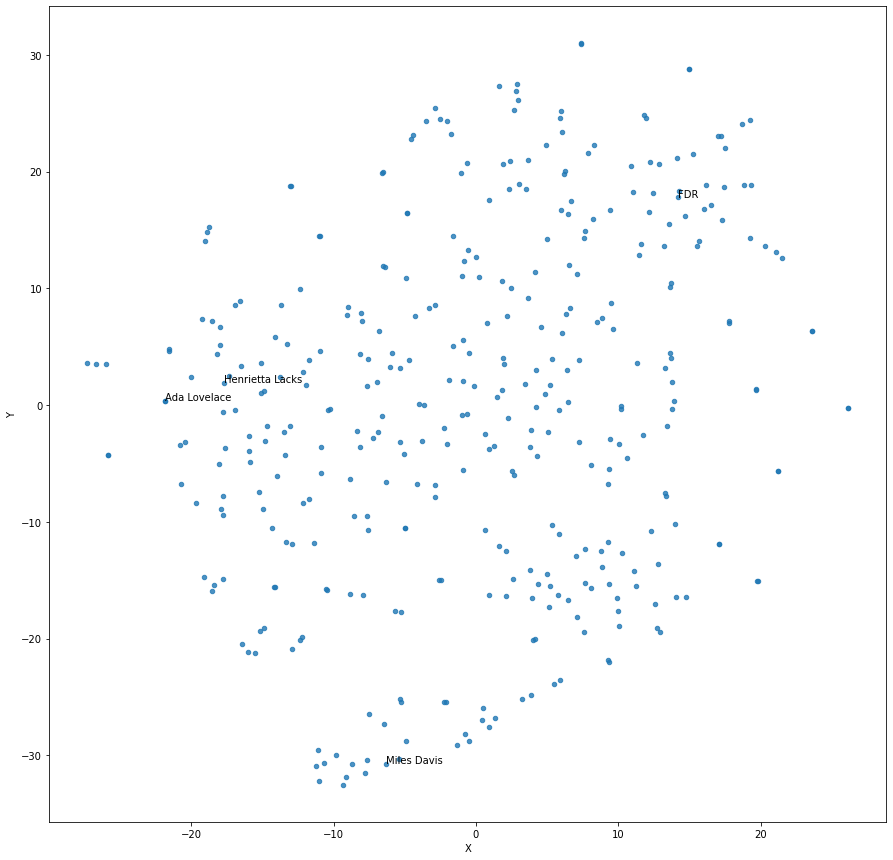

In [13]:
ax = vis_data.plot.scatter(figsize = (15, 15), x = 'X', y = 'Y', alpha = 0.8);
vis_data[vis_data['NAME'].isin(people)][['X', 'Y', 'NAME']].apply(lambda x: ax.text(*x), axis = 1);

```{margin} A caveat
It's important to remember that the transformation between high dimensional space and this 2D plot is a lossy one. 
Distortions will result from it, and having a good sense of what kind of distortions you might expect to see with 
t-SNE will help you interpret these graphs. This [interactive dashboard] offers a really nice overview of these 
considerations.

[interactive dashboard]: https://distill.pub/2016/misread-tsne/
```

As with our toy example above, here, space has semantic value. Points that appear closer together in the 
visualization above have more similarities between them than those that are farther apart. We can see this clearly 
if we show a person's point and the most similar point to that person.

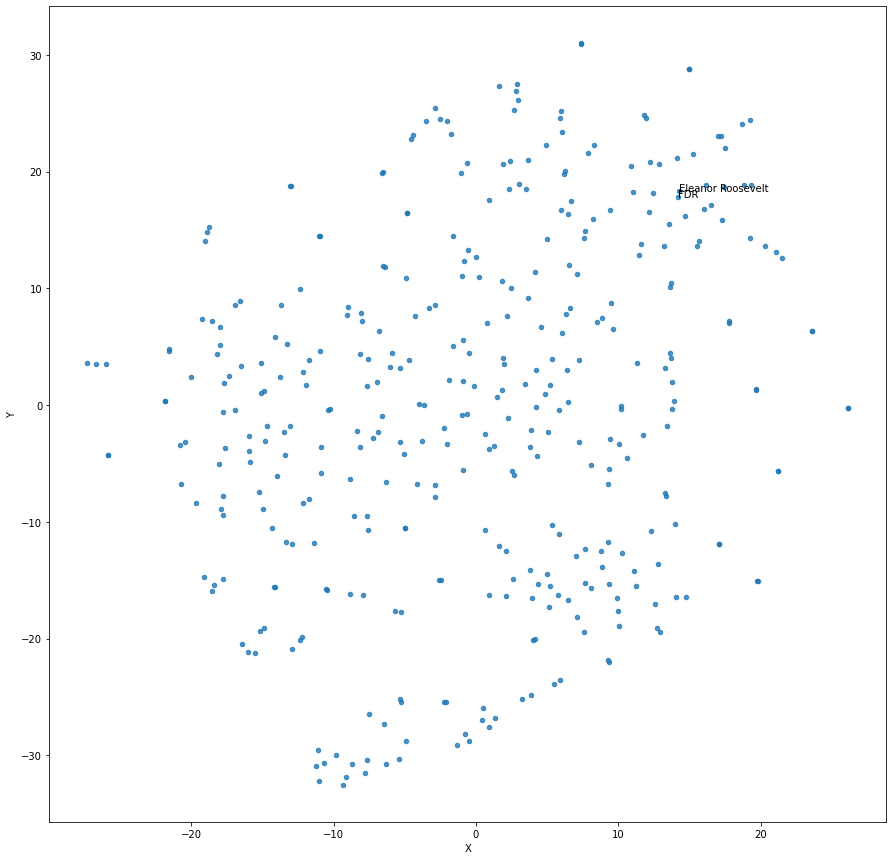

In [14]:
roosevelts = ['FDR', 'Eleanor Roosevelt']

ax = vis_data.plot.scatter(figsize = (15, 15), x = 'X', y = 'Y', alpha = 0.8);
vis_data[vis_data['NAME'].isin(roosevelts)][['X', 'Y', 'NAME']].apply(lambda x: ax.text(*x), axis = 1);

Quite close!

Clustering by Similarity
---------------------------

The last topic we'll cover in this chapter involves dividing up the feature space of our data so as to broadly 
cluster the texts in our corpus. This will give us a frame for considering general trends in the data, which in 
turn may better help us understand the specificity of individual texts. For example, clustering might allow us to 
speak about various subgenres of obituaries. Similarly, it could tell us something about how the _New York Times_ 
writes about particular kinds of people (their vocations, their backgrounds, etc.). It may even indicate something 
about how the style of the obituary has changed over time.

But how to do it? Visual inspection of the graphs above would be one way. There are a few discernible clusters in 
it. Consider the division in points that cuts up toward the right from the bottom center of the graph; there's a 
particularly dense patch of points near the Roosevelts' position as well. But while could slice and dice these 
points using visual cues for ages, these cues can sometimes be misleading. It would be better, then, to use 
unsupervised methods to automatically partition our feature space.

There are a host of different such techniques available. Below, we'll use **hierarchical clustering**. In 
hierarchical clustering, each data point is treated as an individual cluster before being successfully merged with 
its most similar point. Then, this new cluster is merged with another cluster, and the process repeats. Merging 
continues in an upward fashion until the process reaches a predetermined number of clusters.

We can't go into detail about how to determine the best number of clusters for a dataset. It's a complex topic, and 
much depends on a) your data; and b) what you want to know about your data. For now, we'll stick with a general, 
rather rudimentary approach, which you can nuance later on.

Once again, `scikit-learn` has functionality for clustering. We just need to initialize and fit an 
`AgglomerativeClustering()` object to our similarities, defining along the way the number of clusters we'd like to 
generate.

In [15]:
from sklearn.cluster import AgglomerativeClustering

n_clusters = 3
agg = AgglomerativeClustering(n_clusters = n_clusters).fit(similarities)

The result will be a fitted `AgglomerativeClustering()` object, which works much like `CountVectorizer()` or 
`TfidfVectorizer()` in the last chapter. We can access its `labels_` attribute and assign a cluster label to each 
point in our data. We'll also use this attribute to add some color to our visualization, which will make it easier 
to discern the clusters.

In [16]:
vis_data = vis_data.assign(CLUSTER = agg.labels_ + 1)
vis_data = vis_data.assign(COLOR = vis_data['CLUSTER'].replace({1: 'red', 2: 'blue', 3: 'green'}))

And now we can visualize. We'll sample a few names and show those as well.

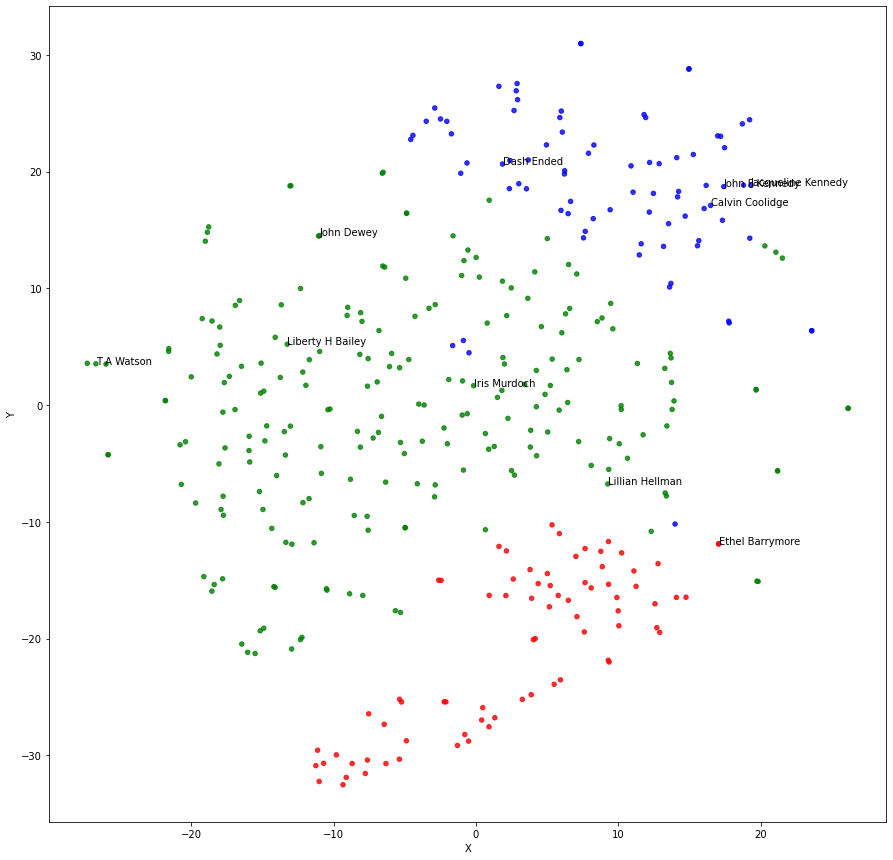

In [17]:
ax = vis_data.plot.scatter(figsize = (15, 15), x = 'X', y = 'Y', c = 'COLOR', alpha = 0.8)
vis_data[['X', 'Y', 'NAME']].sample(10).apply(lambda x: ax.text(*x), axis = 1);

Not bad at all! There are a few incursions of one cluster into another, but for the most part this looks pretty 
coherent (it may even be that those incursions are exaggerated by the visualization, as the note above explains). 
Let's grab some examples of each cluster and show them.

```{margin} What this loop does
1. Group the data by `CLUSTER`
2. For each group, sample `n_samples`
3. Print each name in the sampled results
```

In [18]:
n_samples = 5
for tup in vis_data.groupby('CLUSTER'):
    cluster = tup[0]
    subset = tup[1]
    print(f"Cluster: {cluster}\n----------")
    sampled = subset.sample(n_samples)['NAME']
    for name in sampled:
        print(name)
    print("\n")

Cluster: 1
----------
Otto Klemperer
Sammy Davis Jr
Will Rogers
Galina Ulanova
Louis Armstrong


Cluster: 2
----------
Chiang Kai shek
Cleveland
Calvin Coolidge
Churchill
Elliot Richardson


Cluster: 3
----------
John Muir
A J Dempster
J J Hill
Langston Hughes
Babe Zaharias




Looking over these results turns up an interesting pattern: one way to interpret these clusters is by profession. 
The people in the first cluster tend to be entertainers, usually popular ones working in/with popular media forms; 
Billie Holiday and Marilyn Monroe are in this cluster, for example. Those in the second one, on the other hand, 
tend to be political figures: Ghandi, Adlai Stevenson, and so on. Finally, those in cluster three are often 
novelists, activists, and other kinds of public figures; Helen Keller is in this cluster, along with Joseph 
Pulitzer and Jackie Robinson. From an initial glance, then, our text similarity data seems to suggest that _a 
person's profession indicates something about the type of obituary they have_.

Of course, there are intriguing exceptions. Eugene O'Neill, a playwright, is in the second cluster, whereas the 
division we've just suggested would put him in the third cluster, alongside Sylvia Plath and James Joyce. The Duke 
of Windsor (Edward VIII) is an interesting test case: he is a political figure, though he quickly abdicated from 
the throne. Should he therefore be in the second cluster or, as he is here, in the third cluster?

In [19]:
unexpected = ['Eugene O Neill', 'The Duke of Windsor']
vis_data[vis_data['NAME'].isin(unexpected)][['NAME', 'CLUSTER', 'COLOR']].style.hide_index()

NAME,CLUSTER,COLOR
Eugene O Neill,2,blue
The Duke of Windsor,3,green


The question for both exceptions is why. What is it about these two people – or more specifically, their obituaries 
– that pushes them outside the cluster we'd expect them to be in? Is it a particular set of words? Lexical 
diversity? Something else?

Investigating these questions will take us beyond the scope of this chapter. For now, it's enough to know that text 
similarity prompts them and that we can explore and analyze corpora using this metric. We'll end, then, with this 
preliminary hypothesis about our clusters, which later work will need to either corroborate or challenge.